In [1]:
import jcopdl, luwiji
jcopdl.__version__, luwiji.__version__

('1.1.1', '1.1.2')

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Dataset & Dataloader

In [4]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [5]:

bs = 128
crop_size = 64

train_transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(crop_size, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(70),
    transforms.CenterCrop(crop_size),
    transforms.ToTensor()
])

train_set = datasets.ImageFolder("data/train/", transform=train_transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True, num_workers=4)

test_set = datasets.ImageFolder("data/test/", transform=test_transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle=True)

In [8]:
feature, target = next(iter(trainloader))
feature.shape

torch.Size([128, 3, 64, 64])

In [9]:
label2cat = train_set.classes
label2cat

['invasive', 'noninvasive']

## Arsitektur & Config

In [ ]:
# manual
# nn.Conv2d(3, 8, 3, 1, 1)
# nn.ReLU(),
# nn.MaxPool2d(2, 2)

In [11]:
from jcopdl.layers import conv_block, linear_block

In [13]:
class CustomCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            conv_block(3, 8),
            conv_block(8, 16),
            conv_block(16, 32),
            conv_block(32, 64),
            nn.Flatten()
        ) 
        
        self.fc = nn.Sequential(
            linear_block(1024, 256, dropout=0.1),
            linear_block(256, 2, activation='lsoftmax')
        )
        
        
    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

In [16]:
config = set_config({
    "batch_size": bs,
    "crop_size": crop_size
})

## Training Preparation -> MCOC

In [21]:
model = CustomCNN().to(device)
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir="model")

## Training

In [24]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = correct = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    cost = cost / len(dataset)
    acc = correct / len(dataset)
    return cost, acc



Epoch    15
Train_cost  = 0.4170 | Test_cost  = 0.3841 | Train_score = 0.8100 | Test_score = 0.8425 |




Epoch    16
Train_cost  = 0.4029 | Test_cost  = 0.3693 | Train_score = 0.8190 | Test_score = 0.8400 |
==> EarlyStop patience =  1 | Best test_score: 0.8425




Epoch    17
Train_cost  = 0.3870 | Test_cost  = 0.3658 | Train_score = 0.8210 | Test_score = 0.8550 |




Epoch    18
Train_cost  = 0.3941 | Test_cost  = 0.3611 | Train_score = 0.8280 | Test_score = 0.8500 |
==> EarlyStop patience =  1 | Best test_score: 0.8550




Epoch    19
Train_cost  = 0.3829 | Test_cost  = 0.3478 | Train_score = 0.8240 | Test_score = 0.8525 |
==> EarlyStop patience =  2 | Best test_score: 0.8550




Epoch    20
Train_cost  = 0.3614 | Test_cost  = 0.3406 | Train_score = 0.8270 | Test_score = 0.8650 |


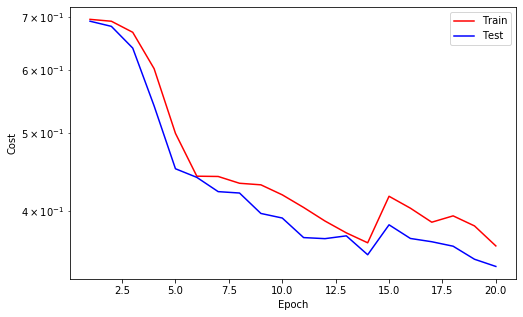

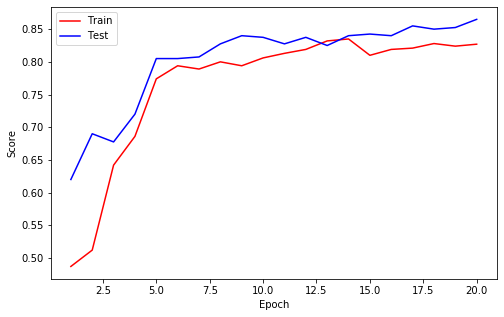



Epoch    21
Train_cost  = 0.3833 | Test_cost  = 0.3575 | Train_score = 0.8300 | Test_score = 0.8450 |
==> EarlyStop patience =  1 | Best test_score: 0.8650




Epoch    22
Train_cost  = 0.4030 | Test_cost  = 0.3440 | Train_score = 0.8200 | Test_score = 0.8650 |
==> EarlyStop patience =  2 | Best test_score: 0.8650




Epoch    23
Train_cost  = 0.3663 | Test_cost  = 0.3309 | Train_score = 0.8420 | Test_score = 0.8675 |




Epoch    24
Train_cost  = 0.3573 | Test_cost  = 0.3538 | Train_score = 0.8400 | Test_score = 0.8300 |
==> EarlyStop patience =  1 | Best test_score: 0.8675




Epoch    25
Train_cost  = 0.3521 | Test_cost  = 0.3858 | Train_score = 0.8450 | Test_score = 0.8150 |
==> EarlyStop patience =  2 | Best test_score: 0.8675




Epoch    26
Train_cost  = 0.3366 | Test_cost  = 0.3365 | Train_score = 0.8580 | Test_score = 0.8475 |
==> EarlyStop patience =  3 | Best test_score: 0.8675




Epoch    27
Train_cost  = 0.3283 | Test_cost  = 0.3049 | Train_score = 0.8570 | Test_score = 0.8725 |




Epoch    28
Train_cost  = 0.3237 | Test_cost  = 0.3117 | Train_score = 0.8520 | Test_score = 0.8650 |
==> EarlyStop patience =  1 | Best test_score: 0.8725




Epoch    29
Train_cost  = 0.3210 | Test_cost  = 0.3243 | Train_score = 0.8620 | Test_score = 0.8500 |
==> EarlyStop patience =  2 | Best test_score: 0.8725




Epoch    30
Train_cost  = 0.3216 | Test_cost  = 0.3175 | Train_score = 0.8580 | Test_score = 0.8600 |
==> EarlyStop patience =  3 | Best test_score: 0.8725




Epoch    31
Train_cost  = 0.3163 | Test_cost  = 0.2864 | Train_score = 0.8690 | Test_score = 0.8900 |




Epoch    32
Train_cost  = 0.3002 | Test_cost  = 0.2906 | Train_score = 0.8760 | Test_score = 0.8775 |
==> EarlyStop patience =  1 | Best test_score: 0.8900




Epoch    33
Train_cost  = 0.3023 | Test_cost  = 0.2737 | Train_score = 0.8800 | Test_score = 0.8775 |
==> EarlyStop patience =  2 | Best test_score: 0.8900




Epoch    34
Train_cost  = 0.2980 | Test_cost  = 0.2704 | Train_score = 0.8740 | Test_score = 0.9000 |




Epoch    35
Train_cost  = 0.3086 | Test_cost  = 0.3865 | Train_score = 0.8640 | Test_score = 0.8225 |
==> EarlyStop patience =  1 | Best test_score: 0.9000




Epoch    36
Train_cost  = 0.3134 | Test_cost  = 0.3114 | Train_score = 0.8750 | Test_score = 0.8600 |
==> EarlyStop patience =  2 | Best test_score: 0.9000




Epoch    37
Train_cost  = 0.3042 | Test_cost  = 0.3037 | Train_score = 0.8760 | Test_score = 0.8600 |
==> EarlyStop patience =  3 | Best test_score: 0.9000




Epoch    38
Train_cost  = 0.2934 | Test_cost  = 0.2895 | Train_score = 0.8800 | Test_score = 0.8725 |
==> EarlyStop patience =  4 | Best test_score: 0.9000




Epoch    39
Train_cost  = 0.2794 | Test_cost  = 0.2927 | Train_score = 0.8840 | Test_score = 0.8675 |
==> EarlyStop patience =  5 | Best test_score: 0.9000
==> Execute Early Stopping at epoch: 39 | Best test_score: 0.9000
==> Best model is saved at model


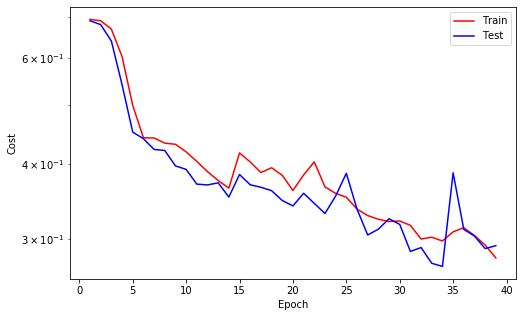

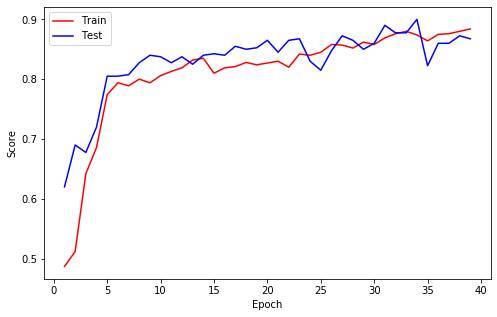

In [25]:
while True:
    train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost, test_score = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost, train_score, test_score)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_score"):
        callback.plot_cost()
        callback.plot_score()
        break

## Predict

In [26]:
feature, target = next(iter(testloader))
feature, target = feature, target = feature.to(device), target.to(device)

In [28]:
with torch.no_grad():
    model.eval()
    output = model(feature)
    preds = output.argmax(1)
preds

tensor([0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0,
        0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,
        1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1,
        0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0,
        1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1,
        0, 1, 0, 1, 1, 1, 1, 0], device='cuda:0')

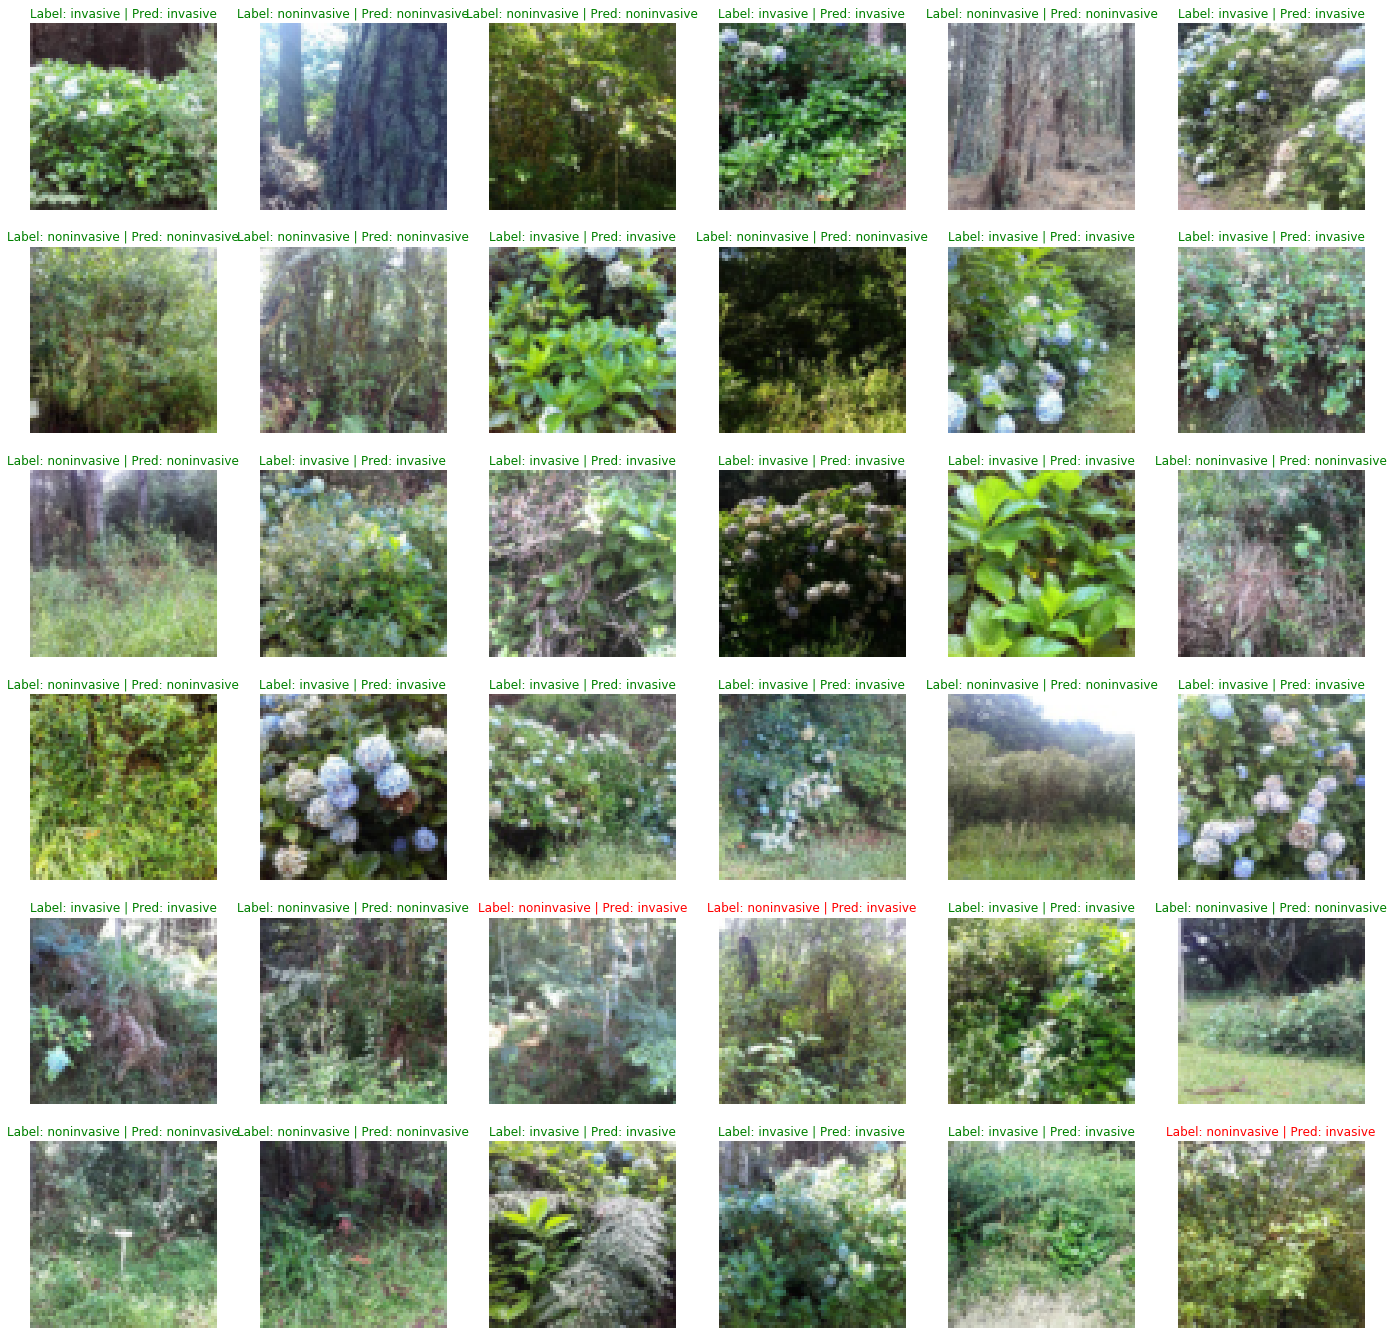

In [30]:
fig, axes = plt.subplots(6, 6, figsize=(24, 24))
for img, label, pred, ax in zip(feature, target, preds, axes.flatten()):
    ax.imshow(img.permute(1, 2, 0).cpu(), cmap='gray')
    font = {"color": 'r'} if label != pred else {"color": 'g'}
    label, pred = label2cat[label.item()], label2cat[pred.item()]
    ax.set_title(f"Label: {label} | Pred: {pred}", fontdict=font);
    ax.axis('off');